In [1]:
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *
from tensorflow.keras.layers import *
from tensorflow.nn import *

In [2]:
n_out = 2
n_hidden = 16

In [3]:
batch_size = 1000
N = 998


encoding_x = tf.placeholder("float", [N, n_out])
with tf.name_scope("encoder"):
    dense0 = leaky_relu(tf.keras.layers.Dense(n_hidden)(encoding_x))
    dense1 = leaky_relu(tf.keras.layers.Dense(n_hidden)(dense0))
    dense2 = tf.keras.layers.Dense(n_out)(dense1)


encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense2, n_out, 50)[0]

In [4]:
n_hidden = 20

x, y = tf.split(dense, n_out, axis=1)

y_ = permute_y(y, N)

h_join = tf.concat([y, x], axis=1)
h_marg = tf.concat([y_, x], axis=1)
learning_rate_encoder = tf.placeholder(tf.float32, shape=[])
learning_rate_estimator = 0.002
with tf.name_scope("estimator"):
    estimator1 = Dense(n_hidden)
    estimator2 = Dense(n_hidden)
    estimator3 = Dense(n_hidden)
    estimator4 = Dense(n_hidden)
    estimator5 = Dense(n_hidden)
    
    def estimator_net_simple(h_join, h_marg, estimator): 
        dense1_joint = leaky_relu(estimator[0](h_join))
        dense2_joint = leaky_relu(estimator[1](dense1_joint))
        dense3_joint = leaky_relu(estimator[2](dense2_joint))
        dense4_joint = leaky_relu(estimator[3](dense3_joint))
        dense5_joint = estimator[4](dense4_joint)

        dense1_marg = leaky_relu(estimator[0](h_marg))
        dense2_marg = leaky_relu(estimator[1](dense1_marg))
        dense3_marg = leaky_relu(estimator[2](dense2_marg))
        dense4_marg = leaky_relu(estimator[3](dense3_marg))
        dense5_marg = estimator[4](dense4_marg)
        return dense5_joint, dense5_marg
    
    dense5_joint, dense5_marg = estimator_net_simple(h_join, h_marg,
                                                   [estimator1, estimator2, estimator3, estimator4, estimator5])

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')


regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)

for var in estimator_var_list:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)


loss = tf.reduce_mean(dense5_joint)-tf.log(tf.reduce_mean(tf.exp(dense5_marg)))
train_encoder     = tf.train.AdamOptimizer(learning_rate_encoder).minimize(loss, var_list=encoder_var_list)
train_step = tf.contrib.opt.NadamOptimizer(learning_rate_estimator).minimize(-(loss+reg_term), var_list=estimator_var_list)

/home/hlynur/.local/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 2
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


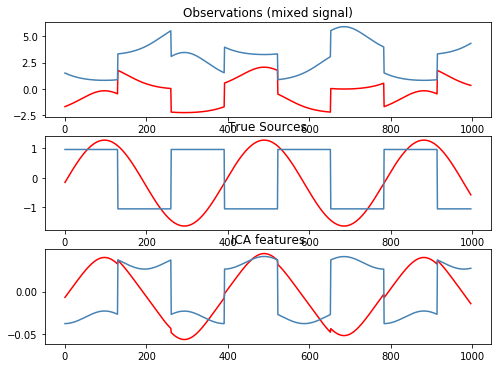

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

time = np.linspace(0, 8, batch_size)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s1 -= np.mean(s1)
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s2 -= np.mean(s2)
S = np.c_[s1, s2]
S += 0.0 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

for t in range(X.shape[0]):    
    X[t, 0] = np.exp(s1[t]) - np.exp(s2[t])
    X[t, 1] = np.exp(-s1[t]) + np.exp(-s2[t])
S = S[1:-1,:]
X = X[1:-1,:]

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue']
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

step: 0, loss: -0.00496315024793148


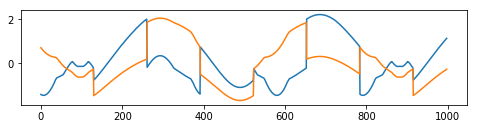

step: 100, loss: 0.07894091308116913
step: 200, loss: 0.18629753589630127
step: 300, loss: 1.3601891994476318
step: 400, loss: 0.8888468742370605


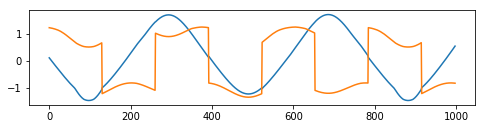

step: 500, loss: 1.0606839656829834
step: 600, loss: -0.09347796440124512
step: 700, loss: 1.206843376159668
step: 800, loss: 0.7743911743164062


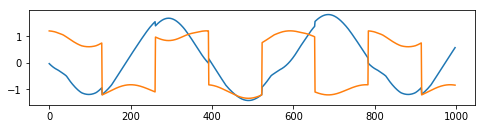

step: 900, loss: 1.0452251434326172
step: 1000, loss: 1.1479697227478027
step: 1100, loss: 1.1660943031311035
step: 1200, loss: 1.2135443687438965


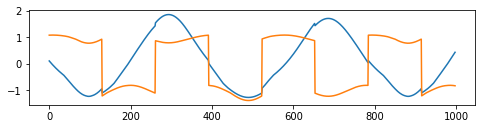

step: 1300, loss: 1.3670730590820312
step: 1400, loss: 1.423135757446289
step: 1500, loss: 0.8349094390869141
step: 1600, loss: 1.3014326095581055


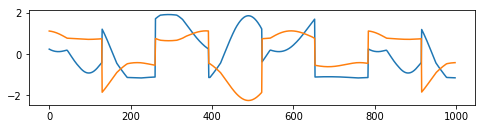

step: 1700, loss: 0.4223175048828125
step: 1800, loss: 0.9425716400146484
step: 1900, loss: 0.7287535667419434
step: 2000, loss: 0.3899192810058594


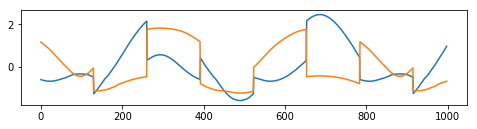

step: 2100, loss: 0.7668113708496094
step: 2200, loss: 1.1128597259521484
step: 2300, loss: 0.5580673217773438
step: 2400, loss: 0.26468753814697266


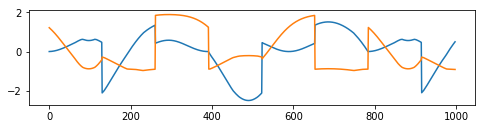

step: 2500, loss: 0.7725152969360352
step: 2600, loss: 0.9636354446411133
step: 2700, loss: 1.0977277755737305
step: 2800, loss: 1.1724424362182617


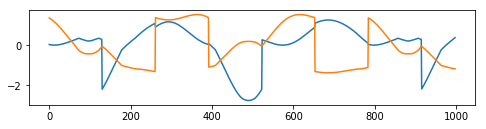

step: 2900, loss: 0.9632759094238281
step: 3000, loss: 1.0588665008544922
step: 3100, loss: 0.9176139831542969
step: 3200, loss: 0.17127704620361328


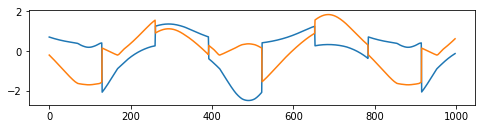

step: 3300, loss: 1.473602294921875
step: 3400, loss: 1.647470474243164
step: 3500, loss: 1.4395904541015625
step: 3600, loss: 0.9114646911621094


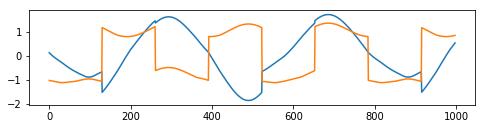

step: 3700, loss: 0.6934795379638672
step: 3800, loss: 0.8101158142089844
step: 3900, loss: 1.151763916015625
step: 4000, loss: 0.07860946655273438


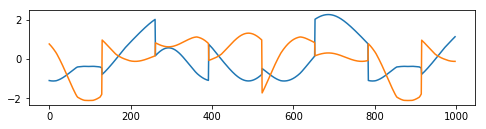

step: 4100, loss: 0.6053028106689453
step: 4200, loss: 0.7151947021484375
step: 4300, loss: 1.1475715637207031
step: 4400, loss: 1.1219749450683594


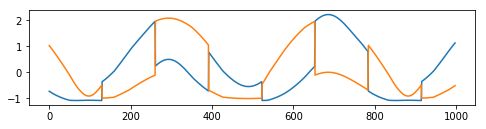

step: 4500, loss: 1.0655326843261719
step: 4600, loss: 0.8739604949951172
step: 4700, loss: 0.8954124450683594
step: 4800, loss: 0.9863929748535156


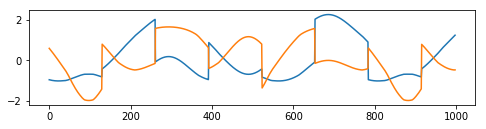

step: 4900, loss: 0.9507083892822266
step: 5000, loss: 0.8300666809082031
step: 5100, loss: 0.96270751953125
step: 5200, loss: 0.9302597045898438


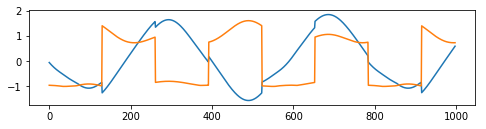

step: 5300, loss: 1.2586441040039062
step: 5400, loss: 1.00372314453125
step: 5500, loss: 1.1024227142333984
step: 5600, loss: 1.1667823791503906


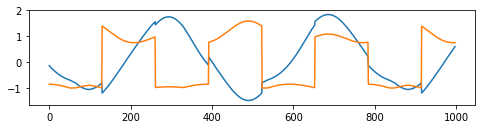

step: 5700, loss: 0.8577919006347656
step: 5800, loss: 0.8100452423095703
step: 5900, loss: 1.0471553802490234
step: 6000, loss: 1.200693130493164


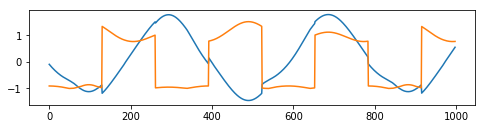

In [6]:
shuffled_x = np.array(X)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(6001):
        current_loss, _ = sess.run([loss, train_step], feed_dict={encoding_x:shuffled_x})
        np.random.shuffle(shuffled_x)
        if i % 4 is 0: 
            current_loss, _ = sess.run([loss, train_encoder], feed_dict={encoding_x:shuffled_x, 
                                                                        learning_rate_encoder:0.004 / (1+0.001*i)})
        if i % 100 is 0: print("step: {}, loss: {}".format(i, current_loss))         
        if i % 400 is 0:
            #v = sess.run(Wx)
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()